
# Environment setup
Make sure to install all required packages

In [1]:
from google.colab import files
import os

import numpy as np
import pandas as pd
from pandas import compat
import matplotlib.pyplot as plt
import seaborn as sns

import re,string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer

from gensim.models import Word2Vec,LdaMulticore, TfidfModel
from gensim import corpora
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, pairwise
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
k = 8
properStopWords =[]
"""
properStopWords = ['abrams',	'cobbs',	'hannah,',	'knight',	'nolan',	'scotts', 'avengers',	'cooper',
                   'harrison', 'lebowski',	'nolans',	'skywalker', 'batman',	'deckard',
                   'harvey',	'ledger'	'pacino'	'spielberg',
'blade',	'denby',	'hauer',	'machina',	'palpatine',	'stark',
'blade runner',	'eckhart',	'hayward',	'martian',	'pesci',	'tolkien',
'blank',	'ex machina',	'hobbits',	'marty',	'preston',	'tyrell',
'blank', 'check',	'fellowship',	'hoffa',	'marvel',	'quigley',	'victoria',
'bonnie',	'forky',	'hooper',	'matrix',	'replicants',	'walle',
'bonsall',	'frank',	'inception',	'mcconaughey',	'ridley',	'wargames',
'brand',	'frodo',	'infinity',	'mcfly',	'rings',	'woody',
'bridges',	'gandalf',	'interstellar',	'merkin',	'runner',	'zemeckis',
'caleb',	'garland',	'irishman',	'michael',	'russel',	
'check',	'george',	'jackson',	'minority',	'russell',	
'christian',	'gordon',	'jeff',	'minority report',	'scorsese',
'christopher',	'gotham',	'joker',	'nathan',	'scott',
]
"""

"\nproperStopWords = ['abrams',\t'cobbs',\t'hannah,',\t'knight',\t'nolan',\t'scotts', 'avengers',\t'cooper',\n                   'harrison', 'lebowski',\t'nolans',\t'skywalker', 'batman',\t'deckard',\n                   'harvey',\t'ledger'\t'pacino'\t'spielberg',\n'blade',\t'denby',\t'hauer',\t'machina',\t'palpatine',\t'stark',\n'blade runner',\t'eckhart',\t'hayward',\t'martian',\t'pesci',\t'tolkien',\n'blank',\t'ex machina',\t'hobbits',\t'marty',\t'preston',\t'tyrell',\n'blank', 'check',\t'fellowship',\t'hoffa',\t'marvel',\t'quigley',\t'victoria',\n'bonnie',\t'forky',\t'hooper',\t'matrix',\t'replicants',\t'walle',\n'bonsall',\t'frank',\t'inception',\t'mcconaughey',\t'ridley',\t'wargames',\n'brand',\t'frodo',\t'infinity',\t'mcfly',\t'rings',\t'woody',\n'bridges',\t'gandalf',\t'interstellar',\t'merkin',\t'runner',\t'zemeckis',\n'caleb',\t'garland',\t'irishman',\t'michael',\t'russel',\t\n'check',\t'george',\t'jackson',\t'minority',\t'russell',\t\n'christian',\t'gordon',\t'jeff',\t'minori



---


# Helper functions
These only need to be run once unless changed

#### EC clean up code 

In [0]:
#the following section is example code to create ECs within the corpus.  A dictionary
#will need to be created for every EC.  Each EC will need to be applied to the corpus.
#Below is an example of how the function works.

def create_ec(dictionary, corpus):
  for key, values in dictionary.items():
      for value in values:
        corpus = (re.sub(r'\b{}\b'.format(value), key, corpus))
  return corpus

#### Function to process documents

In [0]:
def clean_doc(doc): 
    #incorporate ECs
    doc=create_ec(ec_dic, doc)

    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = nltk.corpus.stopwords.words('english')
    stop_words.extend(properStopWords)
    tokens = [w for w in tokens if not w in stop_words]          
    # word stemming    
    # ps=PorterStemmer()
    # tokens=[ps.stem(word) for word in tokens]
    return tokens

####   Function to label encoding

In [0]:
def One_Hot(variable):
    LE=LabelEncoder()
    LE.fit(variable)
    Label1=LE.transform(variable)
    OHE=OneHotEncoder()
    labels=OHE.fit_transform(Label1.reshape(-1,1)).toarray()
    return labels, LE, OHE



---


# Data ingest
Upload corpus, ECs, and process text

#### Upload class corpus

In [6]:
#upload class corpus csv

#this cell is just for Colab -- if you are running this workbook locally,
#place the 'Class Corpus.csv' in the same directory as the workbook and don't run this

!rm -f Class\ Corpus*.csv
files.upload()

Saving Class Corpus.csv to Class Corpus.csv


{'Class Corpus.csv': b',DSI_Title,Text\n0,Martian_1.docx,"Left for dead on the red planet following a scientifically anomalous but narratively necessary windstorm, botanist Mark Watney (Matt Damon, giving\xc2\xa0Cast Away-era Tom Hanks a run for his money) must hunker down for the long haul, knowing that any rescue mission is years away. Luckily, he is quite literally \xe2\x80\x9cthe best botanist on the planet\xe2\x80\x9d, and after declaring that he\xe2\x80\x99ll have to \xe2\x80\x9cscience the shit\xe2\x80\x9d out of his Robinson Crusoe situation, he discovers that it is indeed possible to grow potatoes in his own poo.\n\nThis is just the first of many self-help survivalist discoveries that find Watney entertainingly facing up to the challenge of \xe2\x80\x9cnot dying\xe2\x80\x9d. Armed only with recordings of\xc2\xa0Happy Days\xc2\xa0and his captain\xe2\x80\x99s collection of old-school floor-fillers (like\xc2\xa0Guardians of the Galaxy,\xc2\xa0The Martian\xc2\xa0takes great deligh

#### Import ECs from CSV

In [0]:
#make sure the CSV is in the exact same format as the ECs tab in this google sheet:
#https://docs.google.com/spreadsheets/d/1OONf8pO6Vst3gv41h53XmHcceD9YzNvQe_5BzO8UKl8/edit?usp=sharing
#it also must be named 'StopWords & EC - ECs.csv'

#this cell is just for Colab -- if you are running this workbook locally,
#place the 'StopWords & EC - ECs.csv' in the same directory as the workbook and don't run this

!rm -f StopWords\ \&\ EC\ -\ ECs*.csv
files.upload()

In [0]:
#read in the csv to a dataframe
ec_df = pd.read_csv('StopWords & EC - ECs.csv', header=None)


#get it formatted to play nice
ec_df = ec_df.T
ec_df = ec_df.iloc[0:, 1:]

#convert all characters to lowercase
ec_df = ec_df.applymap(lambda s:s.lower() if type(s) == str else s)

#define first row as column headers (which will be the keys in the dict)
#remove spaces so EC is a single word
ec_df.columns = ec_df.iloc[0].str.replace(' ', '')
ec_df = ec_df.iloc[1:]
ec_df.reset_index(drop=True, inplace=True)

#fill empty cells with 0 so we can process later
ec_df.fillna(0, inplace=True)


#convert df to a dict
ec_dic = ec_df.to_dict('list')


#remove all those zeroes
for item in ec_dic.values():
  try:
    while 0 in item: item.remove(0)
  except:
    continue

print(ec_dic)     

#### Optional: Define ECs manually

Note: this is an alternative to using the procedure above. Running this cell will overwrite `ec_dic` defined in the above cell.

In [0]:
#define your equivalence classes here; one key for each EC
#{EC: ['equivalent term', 'next equivalent term', ...], ...}

ec_dic={}

#### Processing text into lists

In [8]:
#read in class corpus csv into python
data=pd.read_csv('Class Corpus.csv')

#create empty list to store text documents titles
titles=[]
#for loop which appends the DSI title to the titles list
for i in range(0,len(data)):
    temp_text=data['DSI_Title'].iloc[i]
    titles.append(temp_text)

#create empty list to store text documents
text_body=[]
#for loop which appends the text to the text_body list
for i in range(0,len(data)):
    temp_text=data['Text'].iloc[i]
    text_body.append(temp_text)

#Note: the text_body is the unprocessed list of documents read directly form 
#the csv.
#empty list to store processed documents
processed_text=[]
#for loop to process the text to the processed_text list
for i in text_body:
    text=clean_doc(i)
    processed_text.append(text)

#Note: the processed_text is the PROCESSED list of documents read directly form 
#the csv.  Note the list of words is separated by commas.
#stitch back together individual words to reform body of text
final_processed_text=[]
for i in processed_text:
    temp_DSI=i[0]
    for k in range(1,len(i)):
        temp_DSI=temp_DSI+' '+i[k]
    final_processed_text.append(temp_DSI)


#Note: We stitched the processed text together so the TFIDF vectorizer can work.
#Final section of code has 3 lists used.  2 of which are used for further processing.
#(1) text_body - unused, (2) processed_text (used in W2V), 
#(3) final_processed_text (used in TFIDF), and (4) DSI titles (used in TFIDF Matrix)
print(final_processed_text)


['planet following scientifically anomalous narratively necessary windstorm botanist watney damon giving awayera hanks money hunker knowing rescue mission years luckily quite literally botanist declaring robinson crusoe situation discovers indeed possible potatoes first selfhelp survivalist discoveries watney entertainingly facing challenge armed recordings happy collection oldschool floorfillers guardians galaxy martian takes great delight anachronistic retropop stylings lonely starman pitches skills inhospitable elements counting solar arrives mission control fight battles practical geopolitical lifting underlying riffs silent running thirdact visuals alfonso gravity coincidental hints interstellar damon stranded distant planet world jessica chastain chances martian delivers intergalactic spectacle feetinthesoil character drama duncan running finds leading basically talking video diaries delayed digital communications providing handy dramatic framework quipfilled soliloquies damon ma



---


# Document vectorization and term extraction
TF-IDF, Doc2Vec, Word2Vec processing

#### Sklearn TFIDF 

In [0]:
#note the ngram_range will allow you to include multiple words within the TFIDF matrix
#Call Tfidf Vectorizer
Tfidf=TfidfVectorizer(ngram_range=(1,3))

#fit the vectorizer using final processed documents.  The vectorizer requires the 
#stiched back together document.
TFIDF_matrix=Tfidf.fit_transform(final_processed_text)     

#creating datafram from TFIDF Matrix
matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)


#print(TFIDF_matrix)

#### Explore TFIDF Values

In [0]:
average_TFIDF={}
for i in matrix.columns:
    average_TFIDF[i]=np.mean(matrix[i])

average_TFIDF_DF=pd.DataFrame(average_TFIDF,index=[0]).transpose()

average_TFIDF_DF.columns=['TFIDF']

#calculate Q1 and Q3 range
Q1=np.percentile(average_TFIDF_DF, 25)
Q3=np.percentile(average_TFIDF_DF, 75)
IQR = Q3 - Q1
outlier=Q3+(1.5*IQR)

#words that exceed the Q3+IQR*1.5
outlier_list=average_TFIDF_DF[average_TFIDF_DF['TFIDF']>=outlier]

#can export matrix to csv and explore further if necessary
average_TFIDF_DF.head(10)

#### Doc2Vec

In [9]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(final_processed_text)]
model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)

doc2vec_df=pd.DataFrame()
for i in range(0,len(processed_text)):
    vector=pd.DataFrame(model.infer_vector(processed_text[i])).transpose()
    doc2vec_df=pd.concat([doc2vec_df,vector], axis=0)

doc2vec_df=doc2vec_df.reset_index()

doc_titles={'title': titles}
t=pd.DataFrame(doc_titles)

doc2vec_df=pd.concat([doc2vec_df,t], axis=1)

doc2vec_df=doc2vec_df.drop('index', axis=1)

doc2vec_df.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,title
0,-0.002431,0.001280,0.000247,-0.004029,0.002401,-0.004649,0.002393,0.004355,0.004619,0.004446,0.001285,0.004734,0.004923,0.002610,-0.004752,0.003441,-0.004060,-0.000084,-0.003930,0.003250,0.000205,-0.002850,0.003822,-0.003412,0.000838,0.004331,0.002573,0.000389,-0.002700,0.002746,-0.000790,0.001358,0.003863,0.002103,0.003107,-0.004966,0.004053,0.001171,0.004211,0.001678,...,-0.000948,0.002209,0.004397,-0.004203,-0.000518,-0.001592,-0.001115,0.001032,0.004550,0.000455,0.000138,0.004371,0.004771,0.002680,0.001824,0.003843,-0.004554,-0.003582,-0.002363,0.000802,-0.003468,0.003333,-0.003860,-0.002515,-0.003306,-0.001524,0.003793,0.002215,-0.004561,0.002032,0.003906,0.002037,-0.003150,0.003887,0.002434,-0.003179,0.000409,0.001524,0.000551,Martian_1.docx
1,0.003568,-0.003571,0.004277,-0.003739,0.001164,-0.000799,-0.001773,-0.002160,0.004574,-0.003767,-0.003691,-0.001853,-0.004431,-0.000599,-0.000984,-0.002079,0.002639,-0.000117,0.002713,-0.003724,-0.000679,0.003037,0.001689,-0.002830,-0.004049,0.002901,-0.003125,-0.002632,-0.003565,-0.000799,-0.003561,-0.002428,0.003069,-0.000481,0.000252,0.004491,-0.002798,0.001841,0.003838,-0.002301,...,0.003688,-0.002257,-0.002200,0.004612,-0.002294,-0.000255,-0.001190,-0.001578,-0.000843,0.001574,0.000674,-0.002248,0.004657,0.001632,0.003622,-0.002895,-0.000467,0.001450,-0.002838,-0.004473,0.003557,-0.001971,-0.001726,0.003786,0.000663,0.004653,0.003940,-0.002416,-0.002157,0.001155,0.002053,0.004547,0.001585,0.001462,0.001116,0.004507,-0.002961,-0.000500,0.002273,Star_Wars_3.docx
2,0.000888,0.004449,-0.003029,0.001764,-0.001659,0.004488,-0.002256,-0.002517,0.004754,-0.001543,-0.002845,0.000210,0.000329,-0.000419,-0.000325,-0.001602,-0.004082,0.001635,-0.001073,-0.001686,-0.000828,-0.003703,0.000531,-0.000131,-0.002761,0.003863,-0.000781,0.000819,0.001263,-0.003129,0.002762,0.001711,-0.001009,0.000884,-0.004969,-0.004700,0.002026,0.003801,-0.003932,-0.002837,...,-0.003639,-0.002478,0.001830,0.003211,0.001169,-0.004139,-0.002595,0.001557,0.002641,0.001695,-0.000619,0.000055,0.002898,0.004878,0.000106,0.004258,0.002934,0.002834,-0.003118,-0.003629,-0.004902,-0.001609,0.001495,0.000223,-0.003089,0.002584,0.002911,-0.004634,-0.003450,0.001525,0.002078,-0.004744,0.003779,0.000984,-0.002477,-0.001333,0.002098,0.004858,0.002464,Blank_Check_1.docx
3,0.001968,0.000181,-0.003352,-0.004616,0.004771,-0.000773,-0.003685,0.001306,-0.003658,-0.003212,-0.001427,0.000440,0.000258,-0.000871,0.004379,0.004963,0.000745,-0.000976,0.003798,0.002718,0.001285,-0.000561,0.000351,0.003206,-0.001832,0.001466,-0.001370,0.001477,0.001020,-0.000347,-0.004054,0.004925,-0.001337,0.002024,-0.002518,0.000816,-0.000714,-0.002365,-0.001693,-0.001930,...,-0.000383,0.001052,0.004335,-0.003075,0.001281,-0.001027,0.003838,0.003817,0.001198,0.004310,0.002596,-0.002622,0.000092,-0.000502,-0.000030,0.000028,-0.000610,0.000684,0.002715,0.003120,-0.004884,0.000325,-0.000149,0.000292,-0.002993,-0.002126,-0.002310,-0.003631,-0.004517,-0.004177,-0.003787,0.002780,0.003244,-0.002249,0.002180,-0.000223,-0.000903,0.000869,-0.003014,Back_Future_3.docx
4,0.001367,-0.004446,-0.002172,-0.003420,0.002412,-0.001147,0.001191,0.000136,-0.001202,0.002273,-0.000781,0.004568,0.001433,-0.000014,-0.003048,0.003675,-0.003375,-0.004547,-0.004462,0.001779,0.004699,0.002975,-0.001186,-0.004910,0.000491,-0.003553,-0.002840,0.000622,0.004351,-0.003791,-0.003282,-0.001597,-0.000551,-0.002252,-0.000802,-0.004627,0.002193,-0.002189,0.001472,0.002813,...,-0.001648,-0.003250,0.003568,-0.002847,-0.001503,-0.004609,0.000529,-0.001997,0.004863,0.001905,0.004700,-0.002926,-0.001397,-0.001064,0.001067,-0.001460,-0.003944,0.001836,0.002960,-0.004115,0.000913,-0.000345,0.003175,-0.002563,-0.001664,0.003254,0.002879,-0.002124,0.000227,-0.00214

#### Gensim Word2vec 

In [0]:
#Note, there are opportunities to use the word2vec matrix to determine words 
#which are similar.  Similar words can be used to create equivalent classes.  
#k-means is not used to group individual words using the Word2Vec output.

#word to vec
model_w2v = Word2Vec(processed_text, size=100, window=5, min_count=1, workers=4)

#join all processed DSI words into single list
processed_text_w2v=[]
for i in processed_text:
    for k in i:
        processed_text_w2v.append(k)

#obtian all the unique words from DSI
w2v_words=list(set(processed_text_w2v))

#can also use the get_feature_names() from TFIDF to get the list of words
#w2v_words=Tfidf.get_feature_names()

#empty dictionary to store words with vectors
w2v_vectors={}

#for loop to obtain weights for each word
for i in w2v_words:
    temp_vec=model_w2v.wv[i]
    w2v_vectors[i]=temp_vec

#create a final dataframe to view word vectors
w2v_df=pd.DataFrame(w2v_vectors).transpose()

w2v_df.head(10)



---


# Analysis tools
Clustering, Regression, LDA

#### K Means Clustering - TFIDF

In [0]:
k=23
#the following section runs applies the k-means algorithm on the TFIDF matrix.
km = KMeans(n_clusters=k, random_state = 42)
km.fit(TFIDF_matrix)
clusters = km.labels_.tolist()


terms = Tfidf.get_feature_names()
Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

#print("Top terms per cluster:")
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

terms_dict=[]
#save the terms for each cluster and document to dictionaries.  To be used later
#for plotting output.

#dictionary to store terms and titles
cluster_terms={}
cluster_title={}

#print the most important terms
for i in range(k):
    print("\n\nCluster %d:" % i),
    temp_terms=[]
    temp_titles=[]
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
        terms_dict.append(terms[ind])
        temp_terms.append(terms[ind])
    cluster_terms[i]=temp_terms
    
    #print the titles
    print("Cluster %d titles:" % i, end='')
    temp=frame[frame['Cluster']==i]
    for title in temp['Doc Name']:
        print('\n %s,' % title, end='')
        temp_titles.append(title)
    cluster_title[i]=temp_titles

#### Plotting

In [0]:
# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state = 42)

dist = 1 - cosine_similarity(TFIDF_matrix)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 
                  5:'red', 6:'darksalmon', 7:'sienna', 8:'green', 9:'yellow'}


#set up cluster names using a dict.  
cluster_dict=cluster_title

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
fig.suptitle('K = {}'.format(k))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))      #show legend with only 1 point

#### K Means Clustering Doc2Vec

In [10]:
k=8
#The following section of code is to run the k-means algorithm on the doc2vec outputs.
#note the differences in document clusters compared to the TFIDF matrix.
doc2vec_k_means=doc2vec_df.drop('title', axis=1)
km = KMeans(n_clusters=k, random_state = 42)
km.fit(doc2vec_k_means)
clusters_d2v = km.labels_.tolist()

Dictionary={'Doc Name':titles, 'Cluster':clusters_d2v,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

#dictionary to store clusters and respective titles
cluster_title={}

#note doc2vec clusters will not have individual words due to the vector representation
#is based on the entire document not indvidual words. As a result, there won't be individual
#word outputs from each cluster.   
for i in range(k):
    temp=frame[frame['Cluster']==i]
    temp_title_list=[]

    print("\nCluster {}".format(i))
    
    for title in temp['Doc Name']:
        print(title)
        temp_title_list.append(title)
    cluster_title[i]=temp_title_list

print(cluster_title)


Cluster 0
Star_Wars_3.docx
Star_Wars_2.docx
Big_Lebowski_3.docx
Ex_Machina_3.docx
Inception_1.docx
Dark_Knight_1.docx
Toy_Story_2.docx

Cluster 1
Martian_1.docx
Toy_Story_1.docx
Interstellar_1.docx
War_Games_2.docx
Cats_3.docx
Inception_2.docx
Inception_3.docx
Cats_2.docx
Minority_Report_2.docx
Blank_Check_3.docx

Cluster 2
Blank_Check_1.docx
Irishman_2.docx
Minority_Report_1.docx
Big_Short_1.docx
LOTR_2.docx
Irishman_3.docx
Ex_Machina_1.docx
LOTR_1.docx
Big_Short_3.docx
Matrix_3.docx
Star_Wars_1.docx
Walle_3.docx

Cluster 3
LOTR_3.docx
War_Games_3.docx
Dark_Knight2.docx
Minority_Report_3.docx
Big_Lebowski_1.docx
Interstellar_2.docx
Big_Lewbowski_2.docx
Interstellar_4.docx

Cluster 4
Back_Future_2.docx
Cats_1.docx
Gravity_1.docx
Ex_Machina_2.docx
Avengers_1.docx
Irishman_1.docx
Blade_Runner_2.docx

Cluster 5
Walle_1.docx
Blade_Runner_1.docx
Dark_Knight_3.docx
Big_Short_2.docx
War_Games_1.docx

Cluster 6
Back_Future_3.docx
Iron_Man_1.docx
Avengers_2.docx
Matrix_2.docx
Matrix-1.docx
Bac

#### Plotting Doc2vec

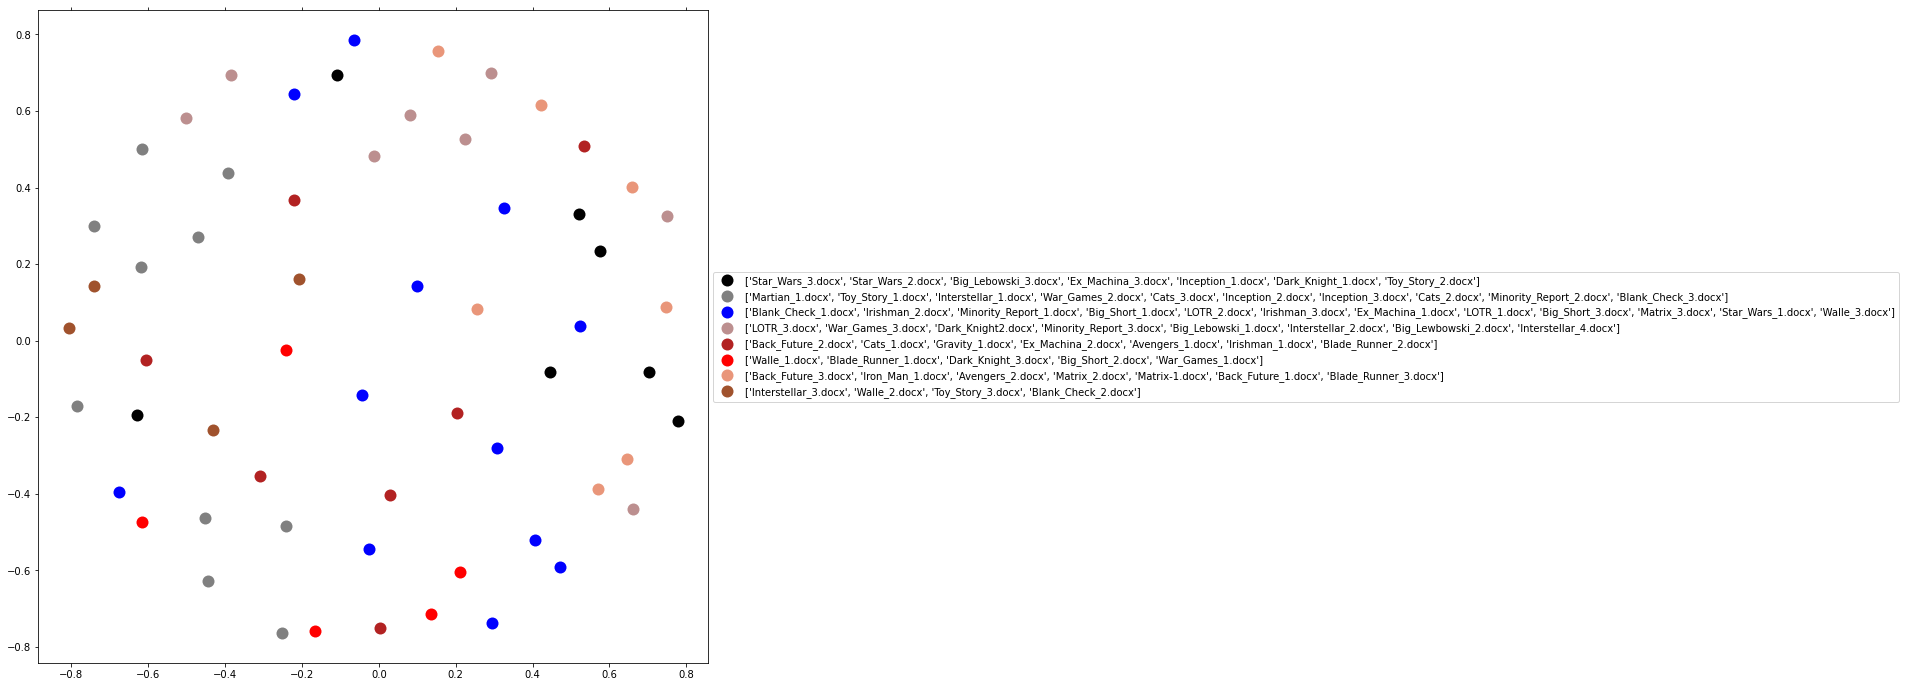

In [11]:
# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state = 42)

dist = 1 - cosine_similarity(doc2vec_k_means)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 
                  5:'red', 6:'darksalmon', 7:'sienna', 8:'green', 9:'yellow', 10:'orange'}


#set up cluster names using a dict.  
cluster_dict=cluster_title         

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters_d2v, title=doc2vec_df.loc[:,'title'] ))

#group by cluster
groups = df.groupby('label')


fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))      #show legend with only 1 point


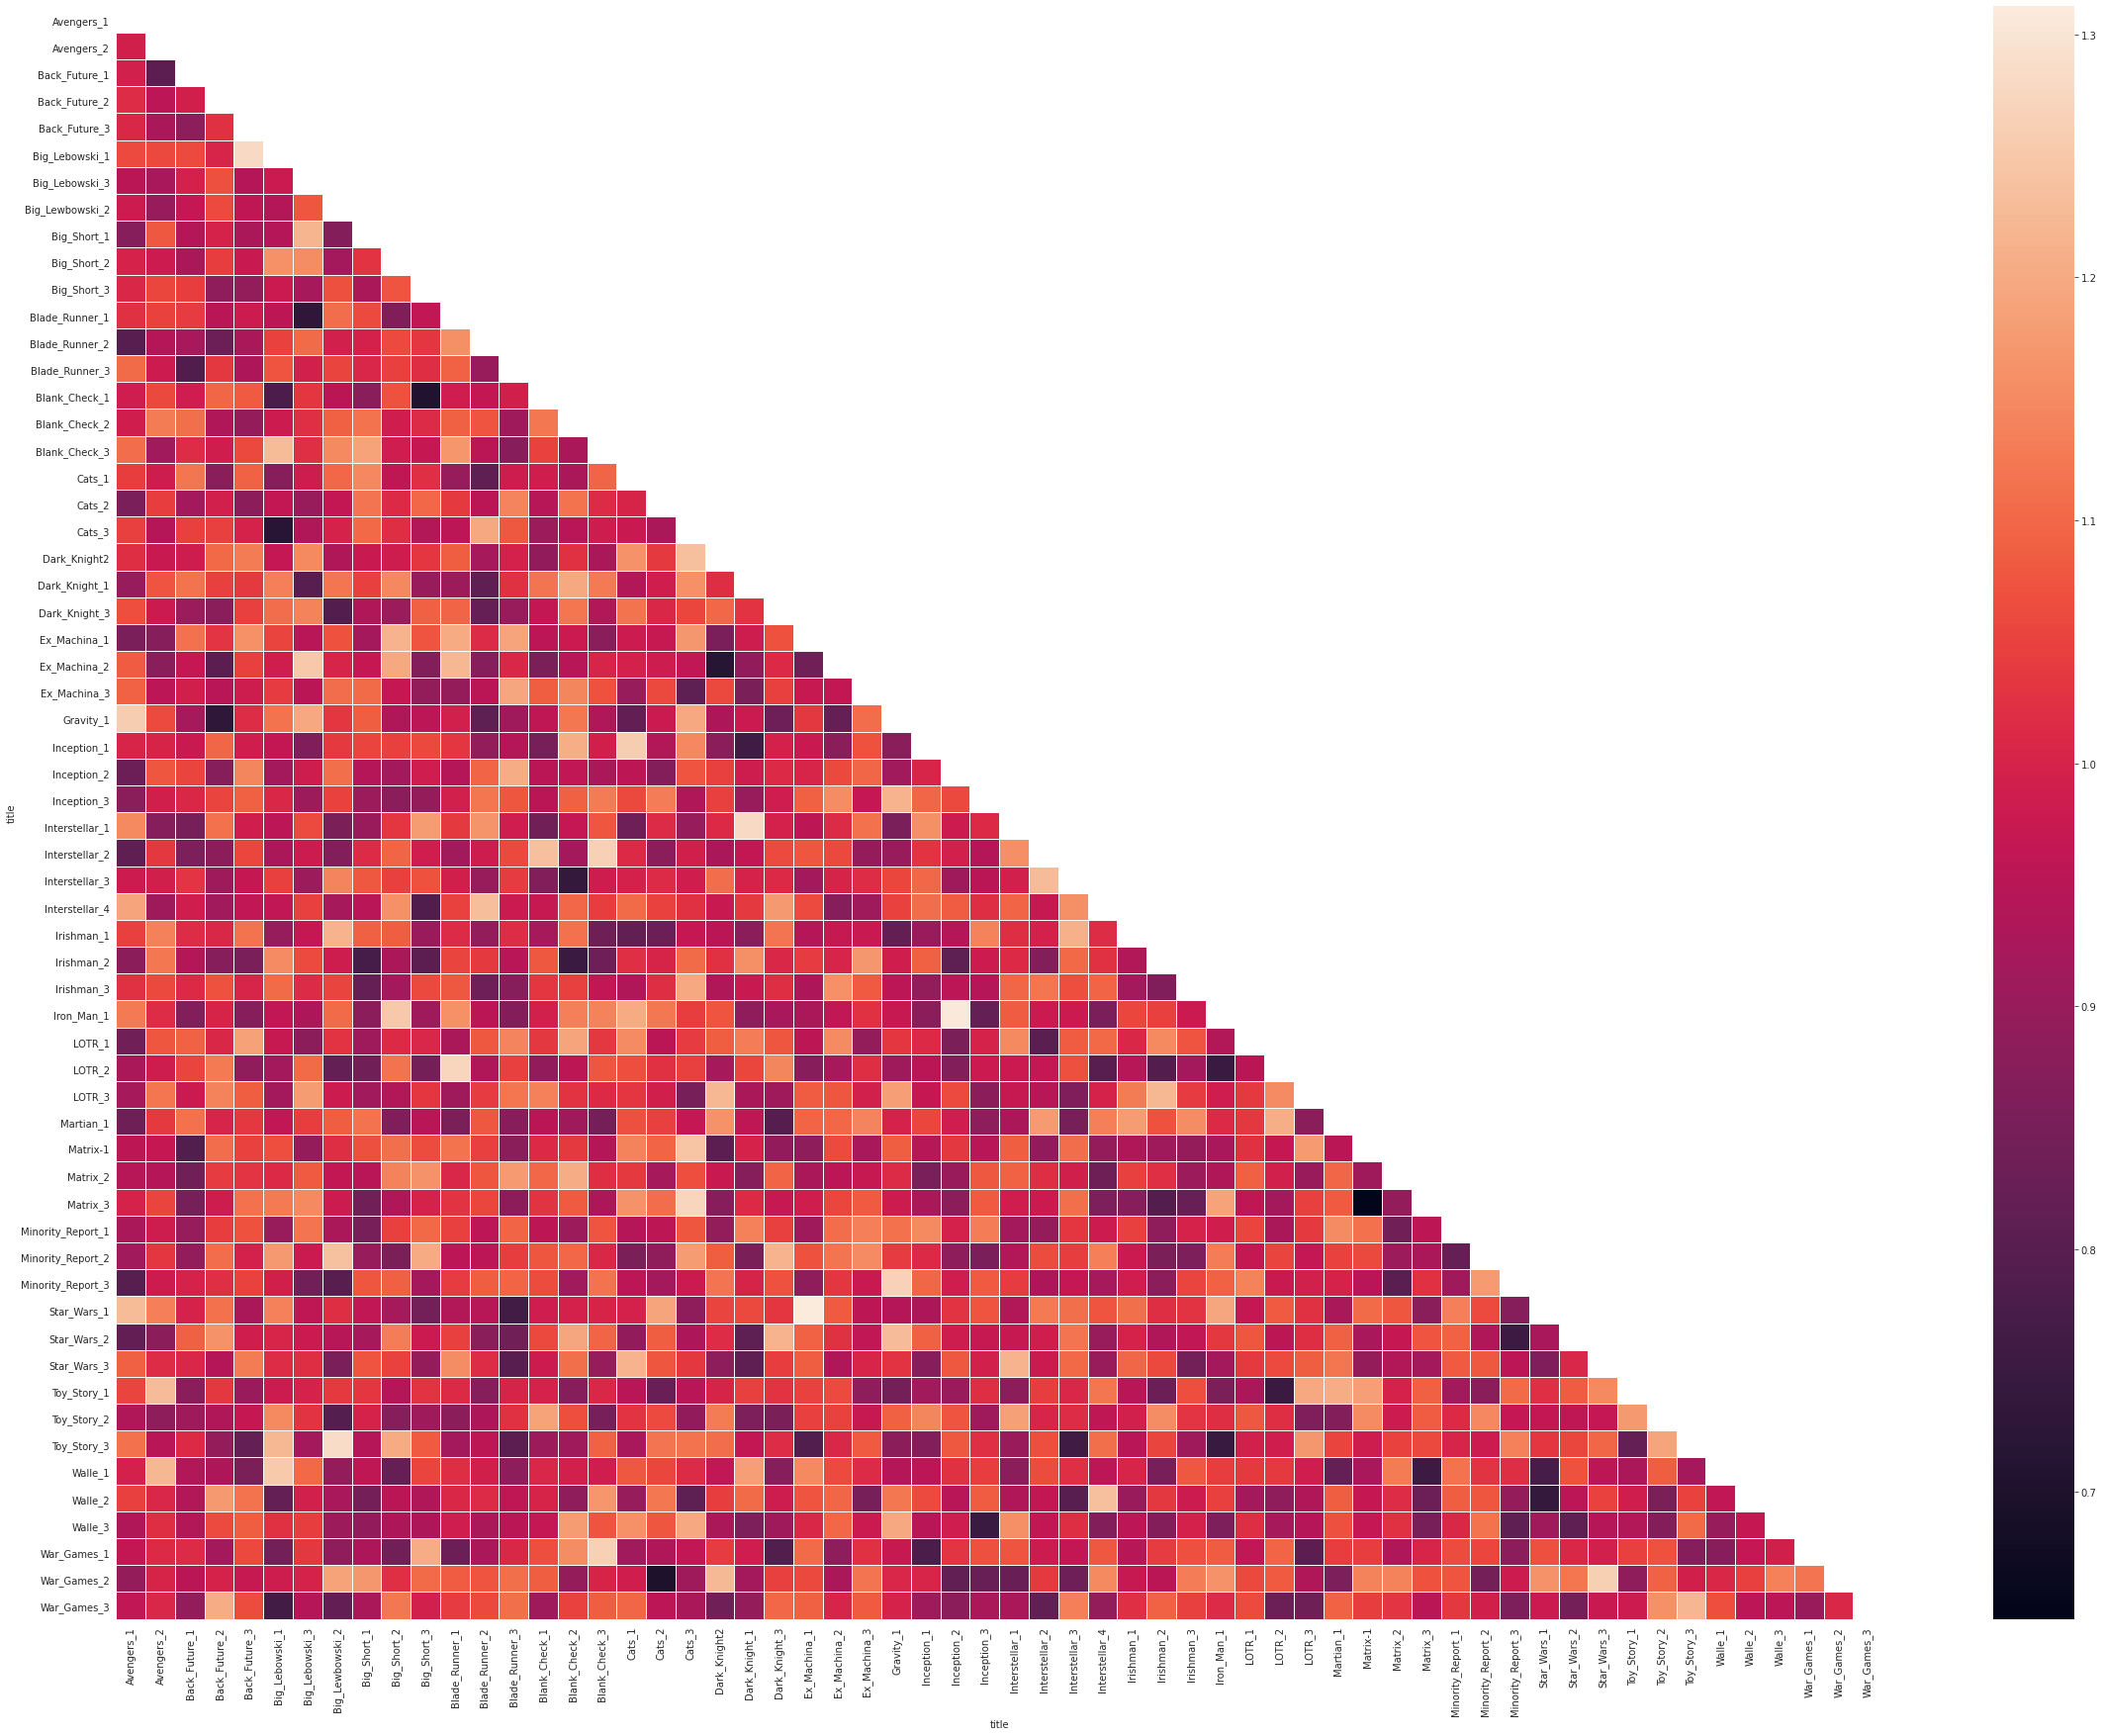

In [13]:
dist = 1 - cosine_similarity(doc2vec_df.iloc[:,0:99])

cos_df = pd.DataFrame(data=dist,
                      index=doc2vec_df.loc[:,'title'].str.replace(".docx", ""),
                      columns=doc2vec_df.loc[:,'title'].str.replace(".docx", "")
                     )

cos_df.sort_values(by='title', axis='index', inplace=True)
cos_df.sort_values(by='title', axis='columns', inplace=True)

#display(cos_df)

#bigger numbers (lighter) means more different
mask = np.zeros_like(cos_df)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
  f, ax = plt.subplots(figsize=(40,30))
  ax = sns.heatmap(cos_df, mask=mask, linewidths=.01)

In [12]:
cos_df = doc2vec_df
cos_df['cluster'] = clusters_d2v 

cluster_list = cos_df['cluster'].unique()
cluster_list = sorted(cluster_list, key=lambda x:x)

for cluster in cluster_list:
  #get only the movies in this cluster
  df = cos_df[cos_df['cluster'] == cluster]
  print("\n\nCluster {}".format(cluster))
  display(df.loc[:, 'title'])
  #calculate their cosine similarities
  dist = 1-cosine_similarity(df.iloc[:,0:99])
  print( "Average Cos Dist is {}".format(np.mean(dist[0])) )
  print( "StD {}".format(np.std(dist[0])))




Cluster 0


1        Star_Wars_3.docx
8        Star_Wars_2.docx
13    Big_Lebowski_3.docx
15      Ex_Machina_3.docx
21       Inception_1.docx
46     Dark_Knight_1.docx
50       Toy_Story_2.docx
Name: title, dtype: object

Average Cos Dist is 0.8126662373542786
StD 0.3394717872142792


Cluster 1


0             Martian_1.docx
5           Toy_Story_1.docx
16       Interstellar_1.docx
17          War_Games_2.docx
33               Cats_3.docx
37          Inception_2.docx
38          Inception_3.docx
44               Cats_2.docx
45    Minority_Report_2.docx
48        Blank_Check_3.docx
Name: title, dtype: object

Average Cos Dist is 0.8770024180412292
StD 0.30965328216552734


Cluster 2


2         Blank_Check_1.docx
9            Irishman_2.docx
14    Minority_Report_1.docx
20          Big_Short_1.docx
26               LOTR_2.docx
27           Irishman_3.docx
28         Ex_Machina_1.docx
32               LOTR_1.docx
39          Big_Short_3.docx
42             Matrix_3.docx
49          Star_Wars_1.docx
52              Walle_3.docx
Name: title, dtype: object

Average Cos Dist is 0.8762507438659668
StD 0.28059521317481995


Cluster 3


12               LOTR_3.docx
18          War_Games_3.docx
23         Dark_Knight2.docx
30    Minority_Report_3.docx
31       Big_Lebowski_1.docx
40       Interstellar_2.docx
56      Big_Lewbowski_2.docx
57       Interstellar_4.docx
Name: title, dtype: object

Average Cos Dist is 0.8617528676986694
StD 0.3416234254837036


Cluster 4


6      Back_Future_2.docx
10            Cats_1.docx
19         Gravity_1.docx
22      Ex_Machina_2.docx
25        Avengers_1.docx
43        Irishman_1.docx
47    Blade_Runner_2.docx
Name: title, dtype: object

Average Cos Dist is 0.7526144981384277
StD 0.3221795856952667


Cluster 5


4            Walle_1.docx
7     Blade_Runner_1.docx
24     Dark_Knight_3.docx
36       Big_Short_2.docx
41       War_Games_1.docx
Name: title, dtype: object

Average Cos Dist is 0.7182264924049377
StD 0.36512190103530884


Cluster 6


3      Back_Future_3.docx
11        Iron_Man_1.docx
29        Avengers_2.docx
34          Matrix_2.docx
51          Matrix-1.docx
53     Back_Future_1.docx
59    Blade_Runner_3.docx
Name: title, dtype: object

Average Cos Dist is 0.8137611746788025
StD 0.33805030584335327


Cluster 7


35    Interstellar_3.docx
54           Walle_2.docx
55       Toy_Story_3.docx
58     Blank_Check_2.docx
Name: title, dtype: object

Average Cos Dist is 0.5744844675064087
StD 0.3323588967323303


#### Classification using various RF Model

In [0]:
#The following section is used to create a model to predict the clusters labels 
#based on the the TFIDF matrix and the doc2vec vectors.  Note the model performance 
#using the two different vectorization methods.
model_RF=RandomForestClassifier(n_estimators=20)

"""
#TFIDF
Y=clusters
x=TFIDF_matrix

#cross validation
cv_score=cross_val_score(model_RF, x, Y, cv=4)

#mean CV score
print("TFDIF RFC mean score: {}".format(np.mean(cv_score)) )
"""

#Doc2Vec
Y=clusters_d2v
x=doc2vec_k_means

#cross validation
cv_score=cross_val_score(model_RF, x, Y, cv=4)

#mean CV score
print("doc2vec RFC mean score: {}".format(np.mean(cv_score)) )

####  LDA Code

In [0]:
k = 5
#LDA using bag of words
dictionary = corpora.Dictionary(processed_text)
corpus = [dictionary.doc2bow(doc) for doc in processed_text]

ldamodel = LdaMulticore(corpus, num_topics=k, id2word=dictionary, passes=2, workers=2)    

print("BOW")
for idx, topic in ldamodel.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))


#LDA using TFIDF
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
ldamodel = LdaMulticore(corpus_tfidf, num_topics=k, id2word=dictionary, passes=2, workers=2)    

print("TFIDF")
for idx, topic in ldamodel.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))